In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
import os

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
from power_prediction.preprocess_data import *
from power_prediction.plotting_functions import *
from power_prediction.util import split_data_train_test
from power_prediction.mlops_framework import *

In [3]:
tqdm.pandas()

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
df = get_data_interpolate_nan()

In [6]:
# Drop unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [7]:
# Drop Date_format, NE5 and NE7
df.drop(columns=['Value_NE5', 'Value_NE7'], inplace=True)

In [9]:
print(df['NE_tot'].head())

0    201302.810344
1    261490.339446
2    260405.732294
3    246961.597140
4    235256.817880
Name: NE_tot, dtype: float64


In [10]:
df.head()

,Date,Hr [%Hr],RainDur [min],StrGlo [W/m2],T [°C],WD [°],WVs [m/s],WVv [m/s],p [hPa],Vacation,Holiday,Year,Month,Day,Hour,Weekday,NE_tot,Corona
0,2015-01-01 00:00:00,89.25,0.0,0.02,-2.09,20.41,1.40,1.40,982.80,1.0,1.0,2015,1,1,0,4,201302.810344,0
1,2015-01-01 01:00:00,90.47,0.0,0.01,-2.48,353.85,0.61,0.60,982.64,1.0,1.0,2015,1,1,1,4,261490.339446,0
2,2015-01-01 02:00:00,89.45,0.0,0.02,-2.46,21.48,1.31,1.31,983.00,1.0,1.0,2015,1,1,2,4,260405.732294,0
3,2015-01-01 03:00:00,89.20,0.0,0.02,-2.63,12.22,1.70,1.66,982.93,1.0,1.0,2015,1,1,3,4,246961.597140,0
4,2015-01-01 04:00:00,89.56,0.0,0.02,-2.77,8.30,1.23,1.21,983.03,1.0,1.0,2015,1,1,4,4,235256.817880,0


## Plot prepared Data

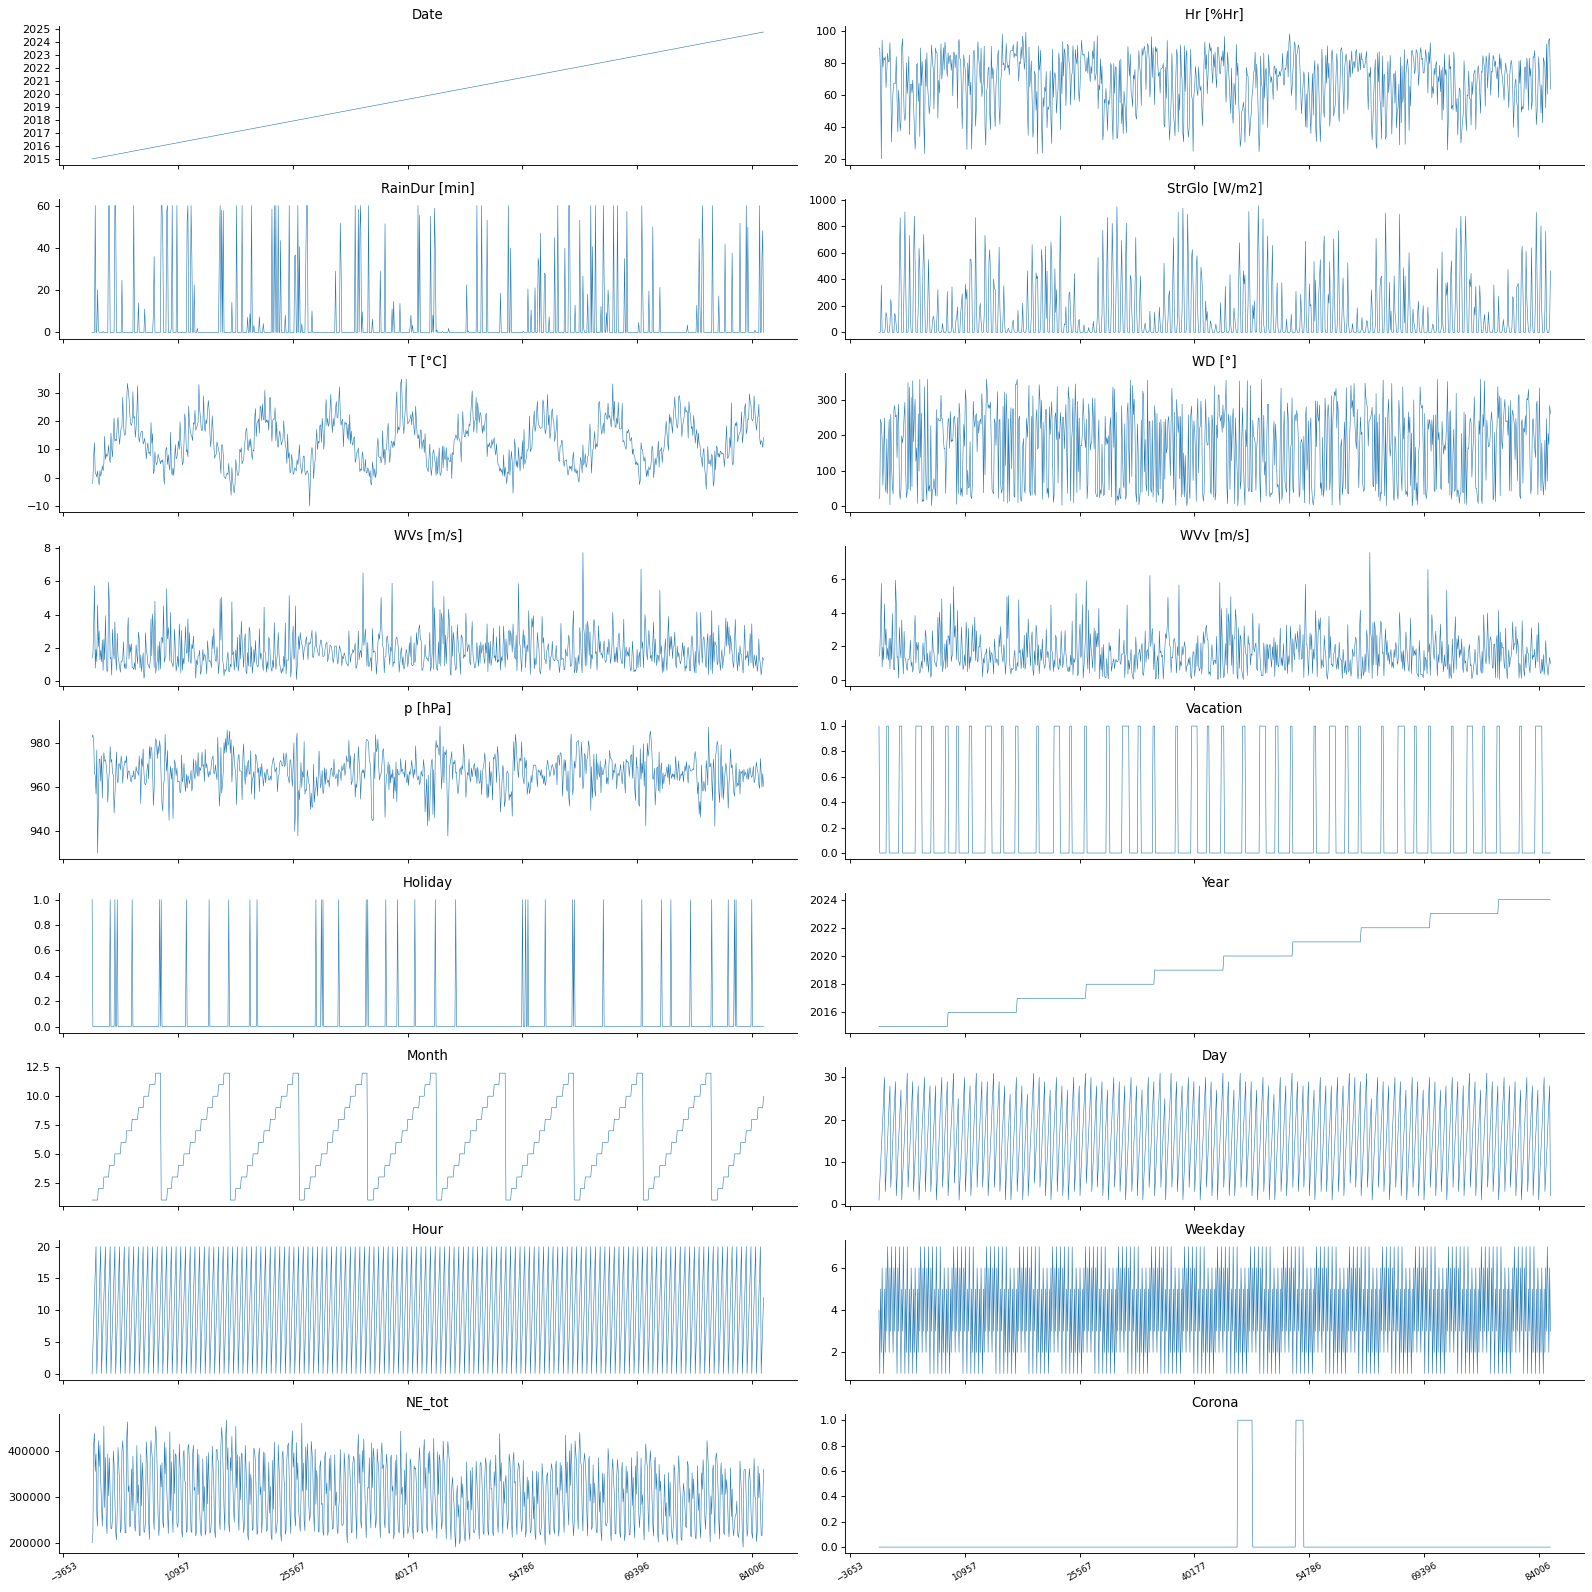

In [11]:
def data_plot(df, sample_interval=100):
    # Sample the DataFrame
    df_plot = df.iloc[::sample_interval, :]  # Adjust the interval as needed

    ncols = 2
    nrows = int(np.ceil(df_plot.shape[1] / ncols))  # Ensure enough rows

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20, 20), dpi=80)
    ax = ax.flatten()  # Flatten the array for easy indexing

    for i, col in enumerate(df_plot.columns):
        ax[i].plot(df_plot.index, df_plot[col], linewidth=0.5)
        ax[i].tick_params(axis="x", rotation=30, labelsize=8)
        ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
        ax[i].set_title(col)
        # Remove top and right spines for aesthetics and performance
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

    # Hide any unused subplots
    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])

    fig.tight_layout()
    plt.show()
    
# Plot the data
data_plot(df, sample_interval=100)


In [14]:
train_df, test_df = split_data_train_test(df)

In [23]:
train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

In [28]:
train_df.head()

,Hr [%Hr],RainDur [min],StrGlo [W/m2],T [°C],WD [°],WVs [m/s],WVv [m/s],p [hPa],Vacation,Holiday,Year,Month,Day,Hour,Weekday,NE_tot,Corona
Date,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,89.25,0.0,0.02,-2.09,20.41,1.40,1.40,982.80,1.0,1.0,2015,1,1,0,4,201302.810344,0
2015-01-01 01:00:00,90.47,0.0,0.01,-2.48,353.85,0.61,0.60,982.64,1.0,1.0,2015,1,1,1,4,261490.339446,0
2015-01-01 02:00:00,89.45,0.0,0.02,-2.46,21.48,1.31,1.31,983.00,1.0,1.0,2015,1,1,2,4,260405.732294,0
2015-01-01 03:00:00,89.20,0.0,0.02,-2.63,12.22,1.70,1.66,982.93,1.0,1.0,2015,1,1,3,4,246961.597140,0
2015-01-01 04:00:00,89.56,0.0,0.02,-2.77,8.30,1.23,1.21,983.03,1.0,1.0,2015,1,1,4,4,235256.817880,0


In [24]:
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (76728, 17)
Testing data shape: (8784, 17)


In [25]:
input_scaler = StandardScaler()
target_scaler = StandardScaler()

In [30]:
# target feature
target_feature = 'NE_tot'

input_features = train_df.columns.drop(target_feature).tolist()

In [31]:
input_features

['Hr [%Hr]',
 'RainDur [min]',
 'StrGlo [W/m2]',
 'T [°C]',
 'WD [°]',
 'WVs [m/s]',
 'WVv [m/s]',
 'p [hPa]',
 'Vacation',
 'Holiday',
 'Year',
 'Month',
 'Day',
 'Hour',
 'Weekday',
 'Corona']

In [32]:
# Fit the scaler
input_scaler.fit(train_df[input_features])
target_scaler.fit(train_df[[target_feature]])

StandardScaler()

In [33]:
# Transform the input features
X_train_scaled = input_scaler.transform(train_df[input_features])
X_test_scaled = input_scaler.transform(test_df[input_features])

# Transform the target variable
y_train_scaled = target_scaler.transform(train_df[[target_feature]])
y_test_scaled = target_scaler.transform(test_df[[target_feature]])

In [34]:
# Convert scaled inputs back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, index=train_df.index, columns=input_features)
X_test_scaled = pd.DataFrame(X_test_scaled, index=test_df.index, columns=input_features)

# Convert scaled targets back to DataFrames
y_train_scaled = pd.DataFrame(y_train_scaled, index=train_df.index, columns=[target_feature])
y_test_scaled = pd.DataFrame(y_test_scaled, index=test_df.index, columns=[target_feature])

## Prepare Data for LSTM Input

In [35]:
sequence_length = 50 


In [38]:
def create_sequences(inputs, targets, sequence_length):
    Xs, ys = [], []
    for i in range(len(inputs) - sequence_length):
        Xs.append(inputs.iloc[i:(i + sequence_length)].values)
        ys.append(targets.iloc[i + sequence_length].values)
    return np.array(Xs), np.array(ys)

# Create sequences
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, sequence_length)

X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, sequence_length)


In [39]:
X_train_backup = X_train
y_train_backup = y_train
X_test_backup = X_test
y_test_backup = y_test

In [40]:
# Convert to PyTorch tensors and transfer to device
X_train = torch.from_numpy(X_train).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)

X_test = torch.from_numpy(X_test).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)


In [41]:
# Create a TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders with a smaller batch size
batch_size = 32 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Define the LSTM Model

In [42]:
# Modify the LSTMModel class
class LSTMModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = False  # Set bidirectional to False

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2,
            bidirectional=self.bidirectional
        )

        self.fc = nn.Linear(hidden_size, 1)  # Adjust input size accordingly

    def forward(self, x):
        device = x.device
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Take output from the last time step
        out = self.fc(out)
        return out


In [43]:
# Instantiate the model
input_size = X_train.shape[2]  # Number of input features
hidden_size = 64             
num_layers = 2                

model = LSTMModel(input_size, hidden_size, num_layers).to(device)

In [44]:
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [45]:
# Adjusted Training Loop with Loss Recording
num_epochs = 50
training_loss = []
validation_loss = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    training_loss.append(avg_train_loss)

    # Validation Loop
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch)
            val_loss = criterion(output, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    validation_loss.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.0336, Val Loss: 0.0112
Epoch [2/50], Train Loss: 0.0100, Val Loss: 0.0129
Epoch [3/50], Train Loss: 0.0078, Val Loss: 0.0093
Epoch [4/50], Train Loss: 0.0064, Val Loss: 0.0094
Epoch [5/50], Train Loss: 0.0056, Val Loss: 0.0078
Epoch [6/50], Train Loss: 0.0049, Val Loss: 0.0087
Epoch [7/50], Train Loss: 0.0044, Val Loss: 0.0073
Epoch [8/50], Train Loss: 0.0044, Val Loss: 0.0069
Epoch [9/50], Train Loss: 0.0037, Val Loss: 0.0083
Epoch [10/50], Train Loss: 0.0035, Val Loss: 0.0080
Epoch [11/50], Train Loss: 0.0032, Val Loss: 0.0071
Epoch [12/50], Train Loss: 0.0030, Val Loss: 0.0094
Epoch [13/50], Train Loss: 0.0028, Val Loss: 0.0090
Epoch [14/50], Train Loss: 0.0026, Val Loss: 0.0102
Epoch [15/50], Train Loss: 0.0024, Val Loss: 0.0079
Epoch [16/50], Train Loss: 0.0023, Val Loss: 0.0105
Epoch [17/50], Train Loss: 0.0023, Val Loss: 0.0107
Epoch [18/50], Train Loss: 0.0022, Val Loss: 0.0080
Epoch [19/50], Train Loss: 0.0019, Val Loss: 0.0084
Epoch [20/50], Train 

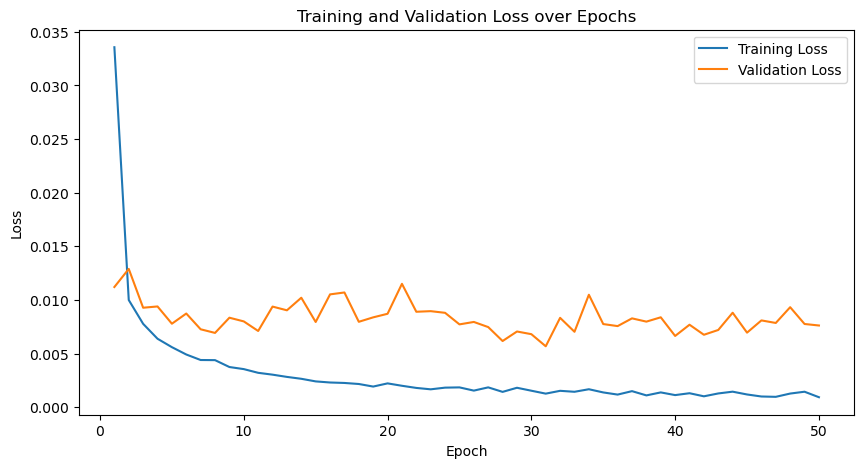

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

## Evaluate the Model

In [47]:
# Create TensorDatasets if not already created
train_eval_dataset = TensorDataset(X_train, y_train)
test_eval_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders with a reasonable batch size (e.g., 32 or 64)
eval_batch_size = 32

train_eval_loader = DataLoader(train_eval_dataset, batch_size=eval_batch_size, shuffle=False)
test_eval_loader = DataLoader(test_eval_dataset, batch_size=eval_batch_size, shuffle=False)


In [48]:
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch)
            predictions.append(output.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
    # Concatenate the lists
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    return predictions, actuals



In [49]:
# Evaluate on training data
y_train_pred, y_train_actual = evaluate_model(model, train_eval_loader, device)

# Evaluate on test data
y_test_pred, y_test_actual = evaluate_model(model, test_eval_loader, device)


In [50]:
# Reshape predictions and actual values to 2D arrays
y_train_pred = y_train_pred.reshape(-1, 1)
y_train_actual = y_train_actual.reshape(-1, 1)

y_test_pred = y_test_pred.reshape(-1, 1)
y_test_actual = y_test_actual.reshape(-1, 1)

# Inverse transform the predictions and actual values
y_train_pred_retransformed = target_scaler.inverse_transform(y_train_pred)
y_train_actual_retransformed = target_scaler.inverse_transform(y_train_actual)

y_test_pred_retransformed = target_scaler.inverse_transform(y_test_pred)
y_test_actual_retransformed = target_scaler.inverse_transform(y_test_actual)



In [51]:
print(f"y_train_pred_retransformed shape: {y_train_pred_retransformed.shape}")
print(f"y_train_actual_retransformed shape: {y_train_actual_retransformed.shape}")
print(f"y_test_pred_retransformed shape: {y_test_pred_retransformed.shape}")
print(f"y_test_actual_retransformed shape: {y_test_actual_retransformed.shape}")


y_train_pred_retransformed shape: (76678, 1)
y_train_actual_retransformed shape: (76678, 1)
y_test_pred_retransformed shape: (8734, 1)
y_test_actual_retransformed shape: (8734, 1)


In [52]:

def evaluate_metrics(y_actual, y_pred, dataset_name=""):
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    
    # Handle division by zero in MAPE calculation
    y_actual_nonzero = np.where(y_actual == 0, 1e-10, y_actual)
    mape = np.mean(np.abs((y_actual - y_pred) / y_actual_nonzero)) * 100
    
    print(f"Metrics for {dataset_name}:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape:.2f}%\n")

In [53]:
# Evaluate metrics on the training set
evaluate_metrics(y_train_actual_retransformed, y_train_pred_retransformed, "Training Set")

# Evaluate metrics on the test set
evaluate_metrics(y_test_pred_retransformed, y_test_actual_retransformed, "Test Set")

Metrics for Training Set:
  Mean Squared Error (MSE): 7501294.5000
  Mean Absolute Error (MAE): 2011.3698
  R-squared (R²): 0.9984
  Mean Absolute Percentage Error (MAPE): 0.66%

Metrics for Test Set:
  Mean Squared Error (MSE): 73558056.0000
  Mean Absolute Error (MAE): 6241.5713
  R-squared (R²): 0.9803
  Mean Absolute Percentage Error (MAPE): 2.16%



In [54]:
dates = test_dates(test_df, y_test_actual)

In [55]:
def line_plot_pred(dates, y_actual, y_pred):
    """
    :param dates: DatetimeIndex generated by test_dates function
    :param y_actual: y_test data
    :param y_pred: the predicted data
    """
    y_actual = y_actual.flatten()
    y_pred = y_pred.flatten()
    
    y_actual_scaled_down = y_actual / 1e3
    y_pred_scaled_down = y_pred / 1e3

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Date': dates,
        'Actual': y_actual_scaled_down,
        'Predicted': y_pred_scaled_down
    })

    # Set the figure size
    plt.figure(figsize=(15, 5))

    # Plot the actual and predicted values
    sns.lineplot(x='Date', y='Actual', data=plot_df, label='Actual', linewidth=2.5, alpha=0.7)
    sns.lineplot(x='Date', y='Predicted', data=plot_df, label='Predicted', linewidth=2)

    # Add title and labels
    plt.title('Power Consumption in Zurich', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Power Consumption [MWh]', fontsize=14)


    plt.ticklabel_format(style='plain', axis='y')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

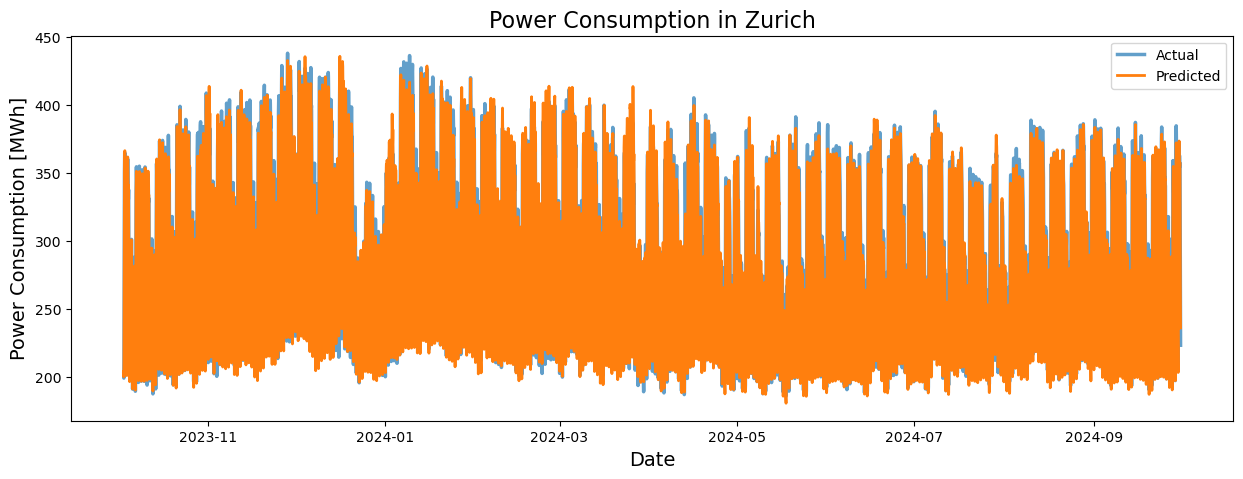

In [42]:
line_plot_pred(dates, y_test_actual_retransformed, y_test_pred_retransformed)

In [56]:
param_dict = {
    "sequence_length": sequence_length,
    "input_size": input_size,  # number of input features
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "loss_function": "SmoothL1Loss",
    "optimizer": "Adam",
    "learning_rate": 0.0005
}

In [59]:
model_name = "Lstm_hourly"

In [60]:
save_model(model_name, model, X_test_backup, y_test_backup, y_test_pred_retransformed, param_dict, model_type="pytorch")

2024/12/06 13:34:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/06 13:34:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'Lstm_hourly'.
Created version '1' of model 'Lstm_hourly'.
